<img align="center" src="images/course.png" width="800">

# 16720 (B)  3D Reconstruction - Assignment 5 - q2
    Instructor: Kris                          TAs: Zen (Lead), Yan, Rawal, Wen-Hsuan, Paritosh, Qichen

In [22]:
# Helper functions for this assignment. DO NOT MODIFY!!!
"""
Helper functions.

Written by Chen Kong, 2018.
Modified by Zhengyi (Zen) Luo, 2021
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import nbimporter
from q1 import eightpoint, camera2, _epipoles, toHomogenous

def epipolarMatchGUI(I1, I2, F):
    matplotlib.use('TkAgg')
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('Select a point in this image')
    ax1.set_axis_off()
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image')
    ax2.set_axis_off()

    while True:
        plt.sca(ax1)
        x, y = plt.ginput(1, mouse_stop=2)[0]

        xc = int(x)
        yc = int(y)
        v = np.array([xc, yc, 1])
        l = F.dot(v)
        s = np.sqrt(l[0]**2+l[1]**2)

        if s==0:
            error('Zero line vector in displayEpipolar')

        l = l/s;

        if l[0] != 0:
            ye = sy-1
            ys = 0
            xe = -(l[1] * ye + l[2])/l[0]
            xs = -(l[1] * ys + l[2])/l[0]
        else:
            xe = sx-1
            xs = 0
            ye = -(l[0] * xe + l[2])/l[1]
            ys = -(l[0] * xs + l[2])/l[1]

        # plt.plot(x,y, '*', 'MarkerSize', 6, 'LineWidth', 2);
        ax1.plot(x, y, '*', MarkerSize=6, linewidth=2)
        ax2.plot([xs, xe], [ys, ye], linewidth=2)

        # draw points
        x2, y2 = epipolarCorrespondence(I1, I2, F, xc, yc)
        ax2.plot(x2, y2, 'ro', MarkerSize=8, linewidth=2)
        plt.draw()

def plot_3D(P):
    matplotlib.use('TkAgg')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(P[:,0], P[:,1], P[:,2])
    while True:
        x, y = plt.ginput(1, mouse_stop=2)[0]
        plt.draw()

        


## Q2: Metric Reconstruction
You will compute the camera matrices and triangulate the 2D points to obtain the 3D scene structure. To obtain the Euclidean scene structure, first convert the fundamental matrix $\textbf{F}$ to an essential matrix $\textbf{E}$. Examine the lecture notes and the textbook to find out how to do this when the internal camera calibration matrices $\textbf{K}_1$ and $\textbf{K}_2$ are known; these are provided in `data/intrinsics.npz`.

### Q2.1: Essential Matrix (5 pt implementation)
Write a function to compute the essential matrix $\textbf{E}$ given $\textbf{F}$, $\textbf{K}_1$ and $\textbf{K}_2$ with the signature:

```
E = essentialMatrix(F, K1, K2)
```



In [23]:
def essentialMatrix(F, K1, K2):
    '''
    Q1.1: Compute the essential matrix E given the fundamental matrix and camera intrinsics
        Input:  F, fundamental matrix
                K1, internal camera calibration matrix of camera 1
                K2, internal camera calibration matrix of camera 2
        Output: E, the essential matrix
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    E = K2.T @ F @ K1
    return E


# matches = np.load("data/some_corresp.npz")
# pts1 = matches["pts1"]
# pts2 = matches["pts2"]
# M = max(np.max(matches["pts1"]), np.max(matches["pts2"]))
# F = eightpoint(pts1, pts2, M)

# intrinsics = np.load("data/intrinsics.npz")
# K1 = intrinsics["K1"]
# K2 = intrinsics["K2"]

# E = essentialMatrix(F, K1, K2)
# print(E)

In [24]:
# Printing out the essential matrix
np.set_printoptions(precision=4, suppress=1)
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
E = essentialMatrix(F, K1, K2)
print(E)

[[  -0.5069   68.6543 -371.9615]
 [  29.7107   -1.5472    9.6823]
 [ 372.9911    2.9855    0.1504]]


In [25]:
# Simple Tests to verify your implmentation:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
E = essentialMatrix(F, K1, K2)
assert(np.linalg.matrix_rank(E) == 2)

# Hidden Tests

### Q2.2 Triangulation and find M2 (5 pt writeup, 20 pt implementation)
Given an essential matrix, it is possible to retrieve the projective camera matrices $\textbf{M}_1$ and $\textbf{M}_2$ from it.  Assuming $\textbf{M}_1$ is fixed at $[\textbf{I},0]$, $\textbf{M}_2$ can be retrieved up to a scale and four-fold rotation ambiguity. For details on recovering $\textbf{M}_2$, see section 7.2 in Szeliski. We have provided you with the function `camera2` to recover as the four possible $\textbf{M}_2$ matrices given $\textbf{E}$.

**Note:** The $\textbf{M}_1$ and $\textbf{M}_2$ here are projection matrices of the form:
$\textbf{M}_1 = \begin{bmatrix}
\textbf{I} | 0
\end{bmatrix} $ and $\textbf{M}_2 = \begin{bmatrix}
\textbf{R} | \textbf{t}
\end{bmatrix} $.

Using the above, write a function to triangulate a set of 2D coordinates in the image to a set of 3D
points with the signature:
```
    [w, err] = triangulate(C1, pts1, C2, pts2)
```
where `pts1` and `pts2` are the $N \times 2$ matrices with the 2D image coordinates and `w` is an $N \times 3$ matrix with the corresponding 3D points per row.  `C1` and `C2` are the $3 \times 4$ camera matrices. Remember that you will need to multiply the given intrinsics matrices with your solution for the canonical camera matrices to obtain the final camera matrices. Various methods exist for triangulation - probably the most familiar for you is based on least squares (see Szeliski Chapter 7 if you want to learn about other methods):

For each point $i$, we want to solve for 3D coordinates $\textbf{w}_i = \begin{bmatrix}x_i, y_i, z_i\end{bmatrix}^T$, such that when they are projected back to the two images, they are close to the original 2D points. To project the 3D coordinates back to 2D images, we first write $\textbf{w}_i$ in homogeneous coordinates, and compute $\mathbf{C}_1 \tilde{\textbf{w}_i}$ and $\mathbf{C}_2 \tilde{\textbf{w}_i}$ to obtain the 2D homogeneous coordinates projected to camera $1$ and camera $2$, respectively.

For each point $i$, we can write this problem in the following form:
\begin{align}
\mathbf{A}_i w_i = 0
\end{align}
where $\mathbf{A}_i$ is a $4\times 4$ matrix, and $\tilde{\textbf{w}_i}$ is a $4\times 1$ vector of the 3D coordinates in the homogeneous form. Then, you can obtain the homogeneous least-squares solution (discussed in class) to solve for each $\textbf{w}_i$.

Once you have implemented triangulation, you can check the performance by looking at the reprojection error:  $$ \texttt{err} = \sum_i ||\textbf{x}_{1i} - \widehat{\textbf{x}_{1i}}||^2 + ||\textbf{x}_{2i} - \widehat{\textbf{x}_{2i}}||^2$$
where $\widehat{\textbf{x}_{1i}} = Proj(\mathbf{C}_1, \textbf{w}_i)$ and $\widehat{\textbf{x}_{2i}} = Proj(\mathbf{C}_2, \textbf{w}_i)$.


**Note:** `C1` and `C2` here are projection matrices of the form:
$\mathbf{C}_1 = \mathbf{K}_1\mathbf{M}_1 = \mathbf{K}_1 \begin{bmatrix}
\textbf{I} | 0
\end{bmatrix} $ and $\mathbf{C}_2 =  \mathbf{K}_2\mathbf{M}_2 = \mathbf{K}_2 \begin{bmatrix}
\textbf{R} | \textbf{t}
\end{bmatrix}$.

Write a function, 
```
    [M2, C2, P] = findM2()
```
to load the correspondences and use triangulation to find the M2, C2, and P that minimize the reprojection error. 

<span style='color:red'>**Output:**</span> In your write-up: Write down the expression for the matrix $\mathbf{A}_i$

In [26]:
def triangle_A(C1, pt1, C2, pt2):
    '''Make a 4x4 A matrix for trangulation, based on each point.

    Basing my work on page 65 in lecture 17, discussing triangulation
    '''
    return np.array([
        pt1[1] * C1[2] - C1[1],
        C1[0] - pt1[0] * C1[2],
        pt2[1] * C2[2] - C2[1],
        C2[0] - pt2[0] * C2[2],
    ])


def triangulate(C1, pts1, C2, pts2):
    '''
    Q2.2: Triangulate a set of 2D coordinates in the image to a set of 3D points.
        Input:  C1, the 3x4 camera matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                C2, the 3x4 camera matrix
                pts2, the Nx2 matrix with the 2D image coordinates per row
        Output: P, the Nx3 matrix with the corresponding 3D points per row
                err, the reprojection error.
    
    ***
    Hints:
    (1) For every input point, form A using the corresponding points from pts1 & pts2 and C1 & C2
    (2) Solve for the least square solution using np.linalg.svd
    (3) Calculate the reprojection error using the calculated 3D points and C1 & C2 (do not forget to convert from 
        homogeneous coordinates to non-homogeneous ones)
    (4) Keep track of the 3D points and projection error, and continue to next point 
    (5) You do not need to follow the exact procedure above. 
    '''
    # ----- TODO -----
    # YOUR CODE HERE

    pts1_homogeneous = np.hstack((pts1, np.ones((len(pts1), 1))))
    pts2_homogeneous = np.hstack((pts2, np.ones((len(pts2), 1))))

    P = []
    for pt1, pt2 in zip(pts1_homogeneous, pts2_homogeneous):
        _, _, vt = np.linalg.svd(triangle_A(C1, pt1, C2, pt2))
        P.append(vt[-1] / vt[-1, -1])
    P = np.array(P)

    pts1_projected = P @ C1.T
    pts1_projected = (pts1_projected.T / pts1_projected[:, -1]).T
    pts2_projected = P @ C2.T
    pts2_projected = (pts2_projected.T / pts2_projected[:, -1]).T

    err =  np.sum(
        np.linalg.norm(pts1 - pts1_projected[:, :2], axis=1)**2 +
        np.linalg.norm(pts2 - pts2_projected[:, :2], axis=1)**2
    )
    
    return P, err
    

def find_M2(F, pts1, pts2, intrinsics):
    '''
    Q2.2: Function to find the camera2's projective matrix given correspondences
        Input:  F, the pre-computed fundamental matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                pts2, the Nx2 matrix with the 2D image coordinates per row
                intrinsics, the intrinsics of the cameras, load from the .npz file
        Output: [M2, C2, P] the computed M2 (3x4) camera projective matrix, C2 (3x4) K2 * M2, and the 3D points P (Nx3)
    
    ***
    Hints:
    (1) Loop through the 'M2s' and use triangulate to calculate the 3D points and projection error. Keep track 
        of the projection error through best_error and retain the best one. 
    (2) Remember to take a look at camera2 to see how to correctly reterive the M2 matrix from 'M2s'. 

    '''
    K1 = intrinsics["K1"]
    K2 = intrinsics["K2"]
    E = essentialMatrix(F, K1, K2)
    M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
    C1 = K1.dot(M1)
    M2s = camera2(E)
    best_error = np.finfo('float').max
    # ----- TODO -----
    # YOUR CODE HERE

    # Try different M2 options, see which has the lowest error
    errors = []
    projected_points = []
    for index in range(M2s.shape[2]):
        M2_option = M2s[:, :, index]
        C2_option = K2 @ M2_option
        P, error = triangulate(C1, pts1, C2_option, pts2)
        # Mark as invalid points that get mapped behind camera 1
        if np.all(P[:, 2] > 0):
            errors.append(error)
            projected_points.append(P)
        else:
            errors.append(np.inf)
            projected_points.append(None)
            
    best_index = np.argmin(errors)
    best_error = errors[best_index]
    M2 = M2s[:, :, best_index]
    C2 = K2 @ M2
    P = projected_points[best_index]
    
    print(f"Best Error {best_error}")
    return M2, C2, P[:, :3]

In [27]:
# Running the find_M2 funciton:
np.set_printoptions(precision=4, suppress=1)
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1, im2 = plt.imread('data/im1.png'), plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M = np.max([*im1.shape, *im2.shape]))
M2, C2, P = find_M2(F, pts1, pts2, intrinsics)
print(f"M2: {M2}")
print(f"C2 {C2}")

Best Error 351.8979669452329
M2: [[ 0.9994  0.0333  0.006  -0.026 ]
 [-0.0337  0.9653  0.2589 -1.    ]
 [ 0.0028 -0.2589  0.9659  0.0796]]
C2 [[ 1520.3898   -27.6331   301.1061   -15.4571]
 [  -50.7634  1409.0488   633.4983 -1506.2442]
 [    0.0028    -0.2589     0.9659     0.0796]]


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/usr/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7f7a9d52ed30>
Exception in Tkinter callback
Traceback (most rec

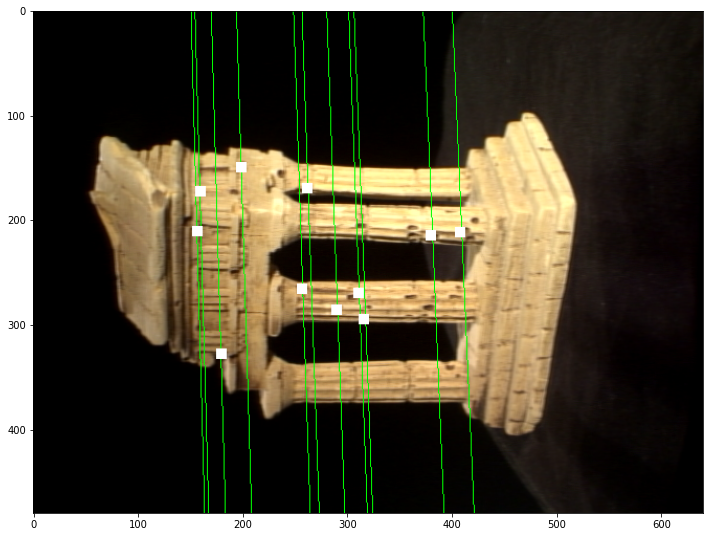

In [59]:
from matplotlib import pyplot

r1 = 5
r2 = 2

# K1 = intrinsics["K1"]
# K2 = intrinsics["K2"]
# M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
# C1 = K1.dot(M1)
# P_homogeneous = np.hstack((P, np.ones((len(P), 1))))

# for image, C, pts in zip([im1.copy(), im2.copy()],
#                          [C1, C2],
#                          [pts1, pts2]):
#     for pt in pts:
#         image[pt[1]-r1:pt[1]+r1, pt[0]-r1:pt[0]+r1] = (1., 1., 1.)

#     projected = P_homogeneous @ C.T
#     projected = (projected.T / projected[:, 2]).T
#     for pt in projected[:, :2]:
#         pt = pt.astype(int)
#         image[pt[1]-r2:pt[1]+r2, pt[0]-r2:pt[0]+r2] = (1., 0., 0.)

#     figure = pyplot.figure(figsize=(12, 12))
#     pyplot.imshow(image)
#     pyplot.show()

image = im2.copy()
C = C2
pts = pts2

E = essentialMatrix(F, K1, K2)
K1_bad = K1.copy()
K1_bad[0, 0] = K1_bad[0, 0] * 1.25
K1_bad[1, 1] = K1_bad[1, 1] * 0.8
K1_bad[1, 2] = K1_bad[1, 2] * 0.9
K1_bad[0, 2] = K1_bad[0, 2] * 1.2
K2_bad = K2.copy()
K2_bad[0, 0] = K2_bad[0, 0] * 1.25
K2_bad[1, 1] = K2_bad[1, 1] * 0.8
K2_bad[1, 2] = K2_bad[1, 2] * 0.9
K2_bad[0, 2] = K2_bad[0, 2] * 1.2
F_bad = np.linalg.inv(K2_bad.T) @ E @ np.linalg.inv(K1_bad)
for x1, y1 in pts1[::10]:
    # Get the epipolar line in image 2
    point = np.array([[x1], [y1], [1.0]])
    epiline = (F_bad @ point).T[0]
    # Loop over all points in the line. ax + by + c = 0, x is the horizontal coordinates,
    # so we can loop over all x, calculate the matching y, and get the correspondence
    a, b, c = epiline
    points = []
    for y2 in range(0, image.shape[0]):
        # Calculate the y value on the epipolar line, then check that it's valid
        x2 = int(-(b * y2 + c) / a)
        if (x2 < 0) or (x2 >= im2.shape[1]):
            continue
        points.append((y2, x2))
        image[y2, x2] = (0, 1, 0)

for pt in pts[::10]:
    image[pt[1]-r1:pt[1]+r1, pt[0]-r1:pt[0]+r1] = (1., 1., 1.)
projected = P_homogeneous @ C.T
projected = (projected.T / projected[:, 2]).T
# for pt in projected[:, :2]:
#     pt = pt.astype(int)
#     image[pt[1]-r2:pt[1]+r2, pt[0]-r2:pt[0]+r2] = (1., 0., 0.)
figure = pyplot.figure(figsize=(12, 12))
pyplot.imshow(image)
pyplot.show()

In [8]:
# Simple Tests to verify your implmentation:
M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
C1 = K1.dot(M1)
C2 = K2.dot(M2)
P_test, err = triangulate(C1, pts1, C2, pts2)
assert(err < 500)

In [9]:
# Hidden Tests

### Q2.3 Epipolar Correspondence (5 pt writeup, 10 pt implementation)

You will now create a 3D visualization of the temple images. By treating our
two images as a stereo-pair, we can triangulate corresponding points in each
image, and render their 3D locations.



Implement a function with the
signature:
```
    [x2, y2] = epipolarCorrespondence(im1, im2, F, x1, y1)
```

This function takes in the $x$ and $y$ coordinates of a pixel on `im1` and your fundamental matrix $\textbf{F}$, and returns the coordinates of the pixel on `im2` which correspond to the input point. The match is obtained by computing the similarity of a small window around the $(x_1, y_1)$ coordinates in `im1` to various windows around possible matches in the `im2` and returning the closest.

Instead of searching for the matching point at every possible location in `im2`, we can use $\textbf{F}$ and simply search over the set of pixels that lie along the epipolar line (recall that the epipolar line passes through a single
point in `im2`  which corresponds to the point $(x_1, y_1)$ in `im1`!.

There are various possible ways to compute the window similarity. For this assignment, simple methods such as the Euclidean or Manhattan distances between the intensity of the pixels should suffice.  See Szeliski Chapter 11, on stereo matching, for a brief overview of these and other methods.


**Implementation hints:**
- Experiments with various window sizes.
- It may help to use a Gaussian weighting of the window, so that the center
  has greater influence than the periphery.
- Since the two images only differ by a small amount, it might be beneficial to consider matches for which the distance from $(x_1, y_1)$ to $(x_2, y_2)$ is small.

To help you test your `epipolarCorrespondence`, we have included a helper function `epipolarMatchGUI`, which takes in two images the fundamental matrix.

This GUI allows you to click on a point in `im1`, and will use your function to display the corresponding point in `im2`. See:

<img align="center" src="images/q3gui_disp_arun.png" width="800">

It's not necessary for your matcher to get **every** possible point right, but it should get easy points (such as those with distinctive corner-like windows).

It should also be good enough to render an intelligible representation in the next question.

<span style='color:red'>**Output:**</span> In your write-up, include a screenshot of `epipolarMatchGUI`
with some detected correspondences.


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/usr/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "/home/eric/.local/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7f7a9d658fd0>
Exception in Tkinter callback
Traceback (most rec

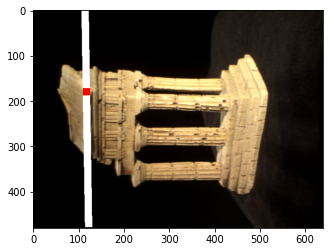

In [19]:
def correspond(im1, im2, pt1, pt2, r=8):
    """Low values = a good match."""
    for value in pt1 + pt2:
        if value - r < 0:
            return np.inf
    if (pt1[0] + r + 1 >= im1.shape[0] or
            pt1[1] + r + 1 >= im1.shape[1] or
            pt2[0] + r + 1 >= im2.shape[0] or
            pt2[1] + r + 1 >= im2.shape[1]):
        return np.inf

    patch1 = im1[pt1[0]-r:pt1[0]+r+1, pt1[1]-r:pt1[1]+r+1]
    patch2 = im2[pt2[0]-r:pt2[0]+r+1, pt2[1]-r:pt2[1]+r+1]
    assert patch1.shape == patch2.shape, \
           print(f"patch1 shape {patch1.shape} should match {patch2.shape}")
    assert patch1.shape[:2] == (2*r+1, 2*r+1), \
           print(f"patch1 shape {patch1.shape[:2]} should match {(2*r+1, 2*r+1)}")

    return np.sum((patch1 - patch2)**2)


def epipolarCorrespondence(im1, im2, F, x1, y1):
    '''
    Q2.3 3D visualization of the temple images.
        Input:  im1, the first image
                im2, the second image
                F, the fundamental matrix
                x1, x-coordinates of a pixel on im1
                y1, y-coordinates of a pixel on im1
        Output: x2, x-coordinates of the pixel on im2
                y2, y-coordinates of the pixel on im2
    
    ***
    Hints:
    (1) Given input [x1, x2], use the fundamental matrix to recover the corresponding epipolar line on image2
    (2) Search along this line to check nearby pixel intensity (you can define a search window) to 
        find the best matches
    (3) Use guassian weighting to weight the pixel simlairty
    
    '''
    # ----- TODO -----
    # YOUR CODE HERE

    # Construct a homogeneous point to use with the fundamental matrix
    point = np.array([[x1], [y1], [1.0]])
    # Get the epipolar line in image 2
    epiline = (F @ point).T[0]
    # Loop over all points in the line. ax + by + c = 0, x is the horizontal coordinates,
    # so we can loop over all x, calculate the matching y, and get the correspondence
    a, b, c = epiline
    errors = []
    points = []
    for y2 in range(0, im2.shape[0]):
        # Calculate the y value on the epipolar line, then check that it's valid
        x2 = int(-(b * y2 + c) / a)
        if (x2 < 0) or (x2 >= im2.shape[1]):
            continue
        errors.append(correspond(im1, im2, (y1, x1), (y2, x2)))
        points.append((y2, x2))
    errors = np.array(errors)
    points = np.array(points)
    
    best_index = np.argmin(errors)
    y2, x2 = points[best_index]

    # Uncomment to visualize the checked patches
    im1 = im1.copy()
    im1[y1-8:y1+8, x1-8:x1+8] = (1.0, 1.0, 1.0)
    pyplot.imshow(im1)
    pyplot.show()
    im2 = im2.copy()
    for eee, ppp in zip(errors, points):
        if eee < 1e6:
            im2[ppp[0]-8:ppp[0]+8, ppp[1]-8:ppp[1]+8] = (1.0, 1.0, 1.0)
    im2[y2-8:y2+8, x2-8:x2+8] = (1.0, 0, 0)
    pyplot.imshow(im2)
    pyplot.show()

    return x2, y2


correspondence = np.load('data/some_corresp.npz')
intrinsics = np.load('data/intrinsics.npz')
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1, im2 = plt.imread('data/im1.png'), plt.imread('data/im2.png')
F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
x2, y2 = epipolarCorrespondence(im1, im2, F, 119, 217)
assert(np.linalg.norm(np.array([x2, y2]) - np.array([118, 181])) < 10)

In [17]:
# Visualization:
np.set_printoptions(precision=4, suppress=1)
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1, im2 = plt.imread('data/im1.png'), plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
epipolarMatchGUI(im1, im2, F)

TclError: invalid command name "pyimage30"

In [12]:
# Simple Tests to verify your implmentation:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1, im2 = plt.imread('data/im1.png'), plt.imread('data/im2.png')
F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
x2, y2 = epipolarCorrespondence(im1, im2, F, 119, 217)

assert(np.linalg.norm(np.array([x2, y2]) - np.array([118, 181])) < 10)



In [13]:
# Hidden Tests

### Q2.4 3D Visualization (3pt writeup, 7 pt implementation) 

Included in this homework  is a file data/templeCoords.npz which contains 288 hand-selected points from `im1` saved in the variables `x1` and `y1`.

Now, we can determine the 3D location of these point correspondences using the `triangulate` function. These 3D point locations can then plotted using the `Matplotlib` package (we have provided the necessary starter code for visualization). An example is shown here: 


|![alt](images/q3a.png) |![alt](images/q3b.png)|
|-|-|
|![alt](images/q3b.png) |![alt](images/q3c.png)|
|-|-|


<span style='color:red'>**Output:**</span> In your write-up: Take a few screenshots of the 3D visualization
so that the outline of the temple is clearly visible.

In [14]:
def compute3D_pts(pts1, intrinsics, F, im1, im2):
    '''
    Q2.4: Finding the 3D position of given points based on epipolar correspondence and triangulation
        Input:  pts1, chosen points from im1
                intrinsics, the intrinsics dictionary for calling epipolarCorrespondence
                F, the fundamental matrix
                im1, the first image
                im2, the second image
        Output: P (Nx3) the recovered 3D points
    
    ***
    Hints:
    (1) Use epipolarCorrespondence to find the corresponding point for [x1 y1] (find [x2, y2])
    (2) Now you have a set of corresponding points [x1, y1] and [x2, y2], you can compute the M2
        matrix and use triangulate to find the 3D points. 
    (3) Use the function findM2 to find the 3D points P (do not recalculate fundamental matrices)
    (4) As a reference, our solution's bet error is around ~2000 on the 3D points. 
    '''
    x1s_temple, y1s_temple = pts1[:, 0], pts1[:, 1]
    # ----- TODO -----
    # YOUR CODE HERE
    
    # (1) Use epipolarCorrespondence to find the corresponding point for [x1 y1] (find [x2, y2])
    pts2 = []
    for x1, y1 in zip(x1s_temple, y1s_temple):
        pts2.append(epipolarCorrespondence(im1, im2, F, x1, y1))
    pts2 = np.array(pts2)

    # (2) Now you have a set of corresponding points [x1, y1] and [x2, y2], you can compute the M2
    # matrix and use triangulate to find the 3D points. 
    M2, C2, P = find_M2(F, pts1, pts2, intrinsics)

    return P[:, :3]


# correspondence = np.load('data/some_corresp.npz') # Loading correspondences
# intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
# templeCoords = np.load("data/templeCoords.npz")
# pts1, pts2 = correspondence['pts1'], correspondence['pts2']
# im1, im2 = plt.imread('data/im1.png'), plt.imread('data/im2.png')
# F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
# temple_pts1 = np.hstack([templeCoords["x1"], templeCoords["y1"]])
# P = compute3D_pts(temple_pts1, intrinsics, F, im1, im2)
# import ipdb; ipdb.set_trace()
# pass

In [15]:
# Visualization:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
templeCoords = np.load("data/templeCoords.npz")
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1, im2 = plt.imread('data/im1.png'), plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))

pts1 = np.hstack([templeCoords["x1"], templeCoords["y1"]])
P = compute3D_pts(pts1, intrinsics, F, im1, im2)

plot_3D(P)


Best Error 526.3647048815386


TclError: invalid command name "pyimage20"

In [ ]:
# Hidden Tests